In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asmitkr","key":"f54eba25974a2896f30f4f7f01d743eb"}'}

In [2]:
# Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                   LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56            993         86  1.0              
thedrcat/daigt-v2-train-dataset                                  DAIGT V2 Train Dataset                             29MB  2023-11-16 01:38:36            487         73  1.0              
muhammadbinimran/housing-price-prediction-data                   Housing Price Prediction Data                     763KB  2023-11-21 17:56:32            998         22  1.0              
thedrcat/daigt-proper-train-dataset                              

In [3]:
!kaggle datasets download -d kazanova/sentiment140

 96% 78.0M/80.9M [00:04<00:00, 20.0MB/s]
100% 80.9M/80.9M [00:04<00:00, 17.1MB/s]


### Unzip the data

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('sentiment140.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Importing the neccessities

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
data_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding='latin-1',names=["target","id","date","flag","user","text"])
data_df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
data_df["target"].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [8]:
data_df.drop(columns=["id","date","flag","user"],axis=1,inplace=True)
data_df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Cleaning the data

In [9]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
data_df["text"] = data_df["text"].apply(lambda x: clean_text(x))
data_df.head()

,target,text
0,0,switchfoot awww thats a bummer you shoulda ...
1,0,is upset that he cant update his facebook by t...
2,0,kenichan i dived many times for the ball manag...
3,0,my whole body feels itchy and like its on fire
4,0,nationwideclass no its not behaving at all im ...


# Random shuffle the data to mix the samples of the two classes perfectly

In [11]:
data_df_shuffled = data_df.sample(frac=1,random_state=20)
data_df_shuffled.head()

,target,text
313228,0,yaeljk get to a show girl do whatcha gotta do ...
253601,0,ex boyfriends suck pete the alien
1041037,4,spaciestaycie which one did you like best
217422,0,damn my back is hella hurtting at work
495067,0,tristanwilds unfortunately my days already over


### Replacing the target representation of positive from 4 to 1

In [12]:
pd.options.mode.chained_assignment = None
data_df_shuffled['target'] = data_df_shuffled['target'].replace(4,1) # 1 positive sentiment
data_df_shuffled['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

### Sorting based on target variable

In [13]:
data_pos = data_df_shuffled[data_df_shuffled['target'] == 1]
data_neg = data_df_shuffled[data_df_shuffled['target'] == 0] #Separating positive and negative tweets
dataset = pd.concat([data_pos, data_neg])
dataset.shape # 80000 each +ve & -ve sentiment

(1600000, 2)

In [14]:
dataset.head()

,target,text
1041037,1,spaciestaycie which one did you like best
1135201,1,earned her cpr amp first aid certifications
921375,1,yay people are following me exciting
1118846,1,mmtnyc see you sooooooon
1215728,1,lol weltonline post zu twitter mit googlead ...


### Removing stopwords from the text

In [15]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [16]:
# Removing stopwords
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

1041037                          spaciestaycie one like best
1135201              earned cpr amp first aid certifications
921375                         yay people following exciting
1118846                                 mmtnyc see sooooooon
1215728    lol weltonline post zu twitter mit googlead zu...
Name: text, dtype: object

### Removing repeating characters

In [17]:
# Removing repeating characters
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

635859                        tristanwilds link doesnt work
11003     go feed herman minute clean room let herman pr...
677333    hey u better not attention thing myinnersexfie...
60534     looks like im not roast looks like im frankiet...
556250    oh love foggy weather iphoneipod os software b...
Name: text, dtype: object

### Tokenizing the text data

In [18]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\s+', gaps = True)
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

In [19]:
dataset['text'].head()

1041037                     [spaciestaycie, one, like, best]
1135201       [earned, cpr, amp, first, aid, certifications]
921375                    [yay, people, following, exciting]
1118846                             [mmtnyc, see, sooooooon]
1215728    [lol, weltonline, post, zu, twitter, mit, goog...
Name: text, dtype: object

### Stemming the text data

In [20]:
import nltk
from functools import lru_cache
st = nltk.PorterStemmer()
stem = lru_cache(maxsize=50000)(st.stem)
def stemming_on_text(data):
    text = [stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

1041037                     [spaciestaycie, one, like, best]
1135201       [earned, cpr, amp, first, aid, certifications]
921375                    [yay, people, following, exciting]
1118846                             [mmtnyc, see, sooooooon]
1215728    [lol, weltonline, post, zu, twitter, mit, goog...
Name: text, dtype: object

### Applying lemmatizer

In [21]:
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [22]:
lm = nltk.WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(lm.lemmatize)
def lemmatizer_on_text(data):
    text = [lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

1041037                     [spaciestaycie, one, like, best]
1135201       [earned, cpr, amp, first, aid, certifications]
921375                    [yay, people, following, exciting]
1118846                             [mmtnyc, see, sooooooon]
1215728    [lol, weltonline, post, zu, twitter, mit, goog...
Name: text, dtype: object

In [23]:
dataset.head()

,target,text
1041037,1,"[spaciestaycie, one, like, best]"
1135201,1,"[earned, cpr, amp, first, aid, certifications]"
921375,1,"[yay, people, following, exciting]"
1118846,1,"[mmtnyc, see, sooooooon]"
1215728,1,"[lol, weltonline, post, zu, twitter, mit, goog..."


### WordCloud for negative sentiment

(-0.5, 1599.5, 799.5, -0.5)

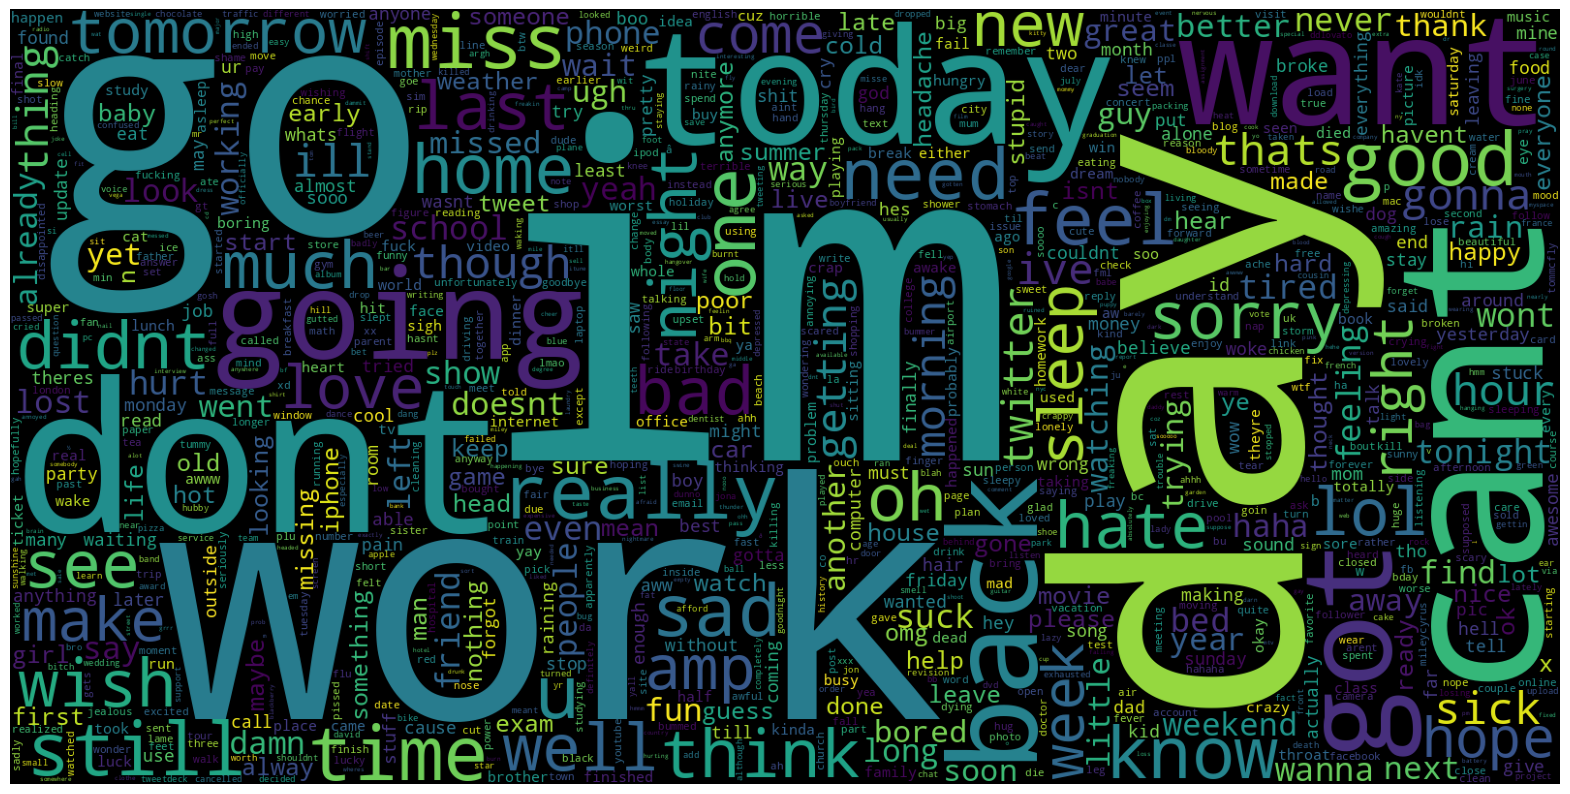

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
data_neg = dataset[dataset['target']==0]['text'].apply(lambda x: ' '.join(x) )
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.axis('off')

### WordCloud for positive words

(-0.5, 1599.5, 799.5, -0.5)

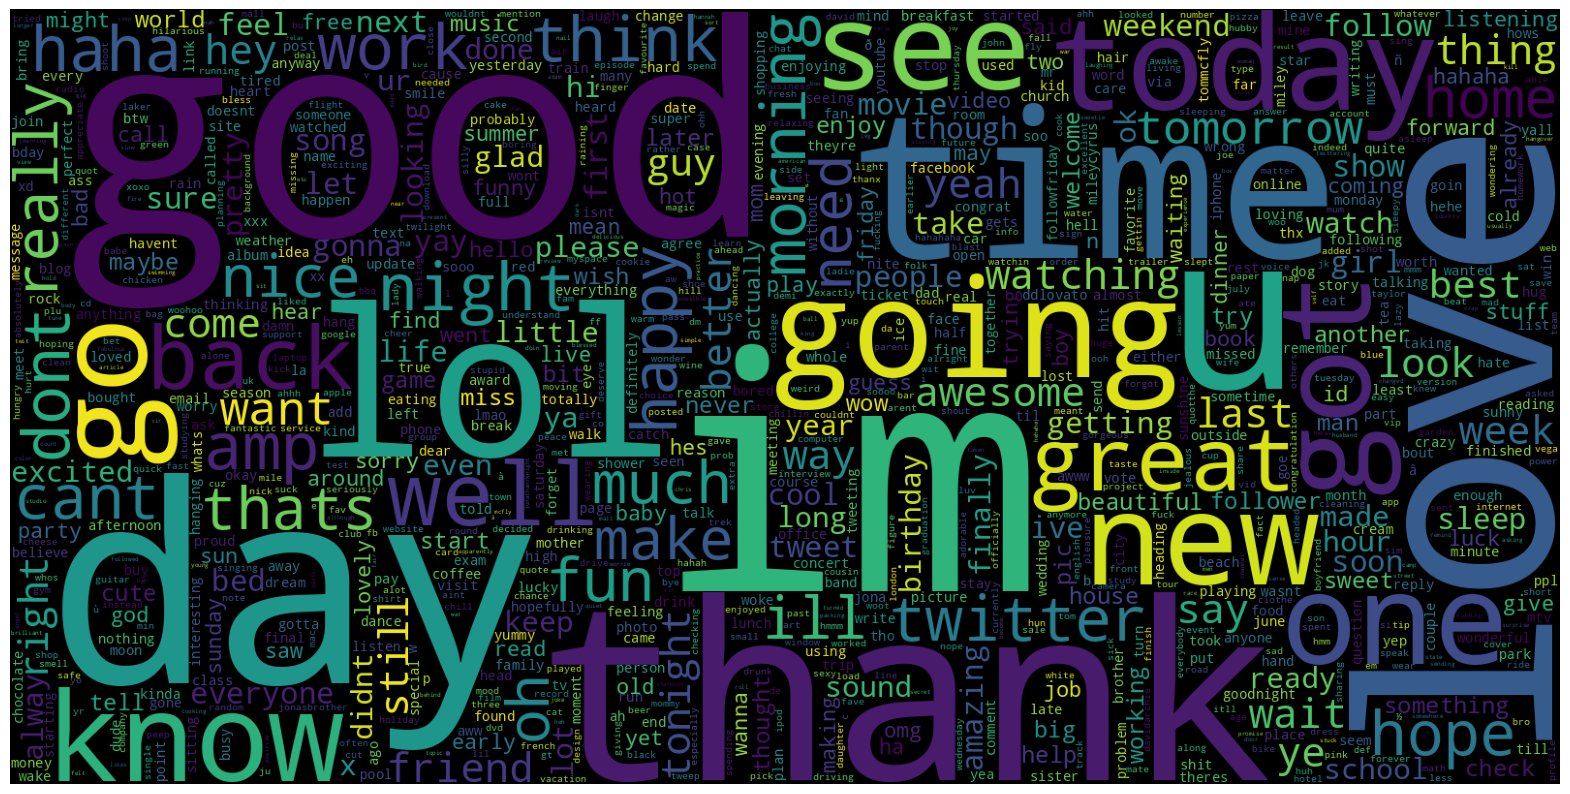

In [25]:
data_pos = dataset[dataset['target']==1]['text'].apply(lambda x: ' '.join(x) )
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)
plt.axis('off')

In [26]:
words = set()
for data in dataset['text']:
    for word in data:
        words.add(word)

len(words)

701417

### Rejoining the tokens to a sentence format

In [27]:
new_data=dataset
new_data['text'] = dataset['text'].apply(lambda x: ' '.join(x) )
new_data.head()

,target,text
1041037,1,spaciestaycie one like best
1135201,1,earned cpr amp first aid certifications
921375,1,yay people following exciting
1118846,1,mmtnyc see sooooooon
1215728,1,lol weltonline post zu twitter mit googlead zu...


In [28]:
new_data.tail()

,target,text
635859,0,tristanwilds link doesnt work
11003,0,go feed herman minute clean room let herman pr...
677333,0,hey u better not attention thing myinnersexfie...
60534,0,looks like im not roast looks like im frankiet...
556250,0,oh love foggy weather iphoneipod os software b...


## Split data into train and validation sets

In [29]:
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)
train_sentences,val_sentences, train_labels,val_labels = train_test_split(new_data['text'].to_numpy(),
                                                                          new_data["target"].to_numpy(),
                                                                          test_size=0.2,
                                                                          random_state=42)

In [30]:
# Check the lengths
len(train_sentences),len(val_sentences), len(train_labels),len(val_labels)

(1280000, 320000, 1280000, 320000)

In [31]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['needs viagra no not internet connection like seriously wtf keep dropping',
        'headache missing dog tomorrow going visit grandma',
        'pidgen no longer connects mozilla often closes wont reopen view calendar ubuntu machine slowing dieing',
        'kimoraklein dont mind asking',
        'half hour left teen nervous turnout quotpartyquot',
        'hours checkout chick hours go', 'im pincushion',
        'dinnerlove dont know stop worst food',
        'rvzb awww becca looked sad earlier',
        'wish could come stupid bilo'], dtype=object),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))

## Modelling on the text dataset

### Model 0: Naive Bayes

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [33]:
# Evaluate our baseline model
model_0_score = model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of: {model_0_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.46%


### Creating an evalution function for our model's experiment

In [34]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy,precision,recall, f1-score of a binary classification model.
  """

  model_accuracy = accuracy_score(y_true,y_pred)
  # Find precision,recall,f1 using weighted average
  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1-score":model_f1}
  return model_results


### Creating a function to plot the confusion matrix for our experiment models

In [35]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [36]:
# Make predictiions
model_0_preds = model_0.predict(val_sentences)
model_0_preds[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [37]:
# Get baseline results
model_0_results = calculate_results(val_labels,model_0_preds)
model_0_results

{'accuracy': 0.794584375,
 'precision': 0.7946488160313216,
 'recall': 0.794584375,
 'f1-score': 0.794566164196341}

### Confusion matrix for our MultinomialNB

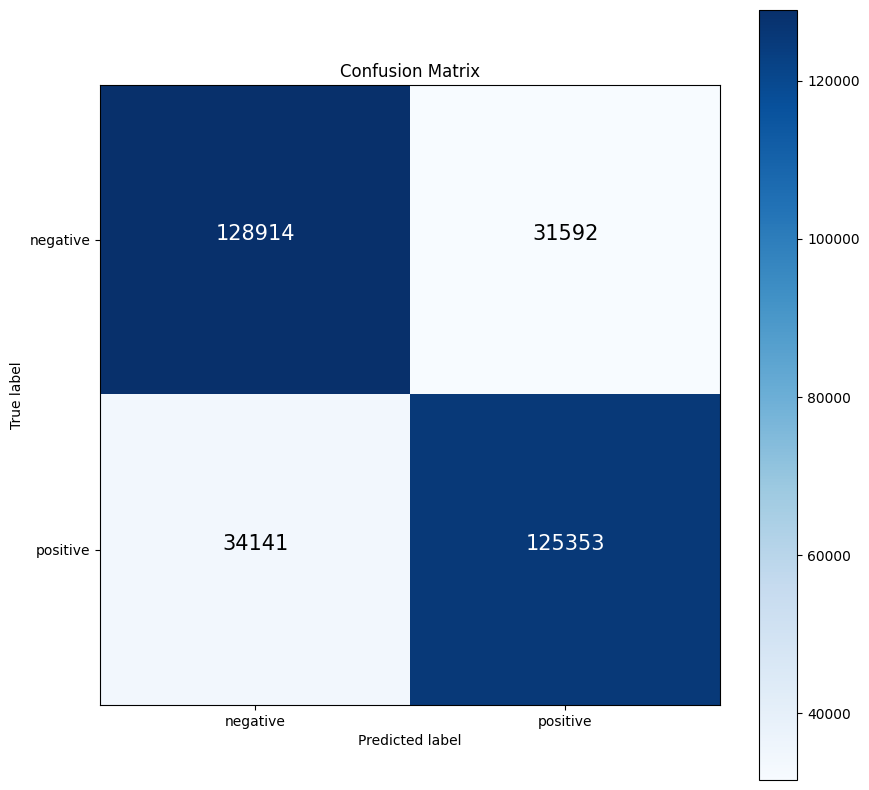

In [38]:
make_confusion_matrix(val_labels,model_0_preds,classes=["negative","positive"])

## Model 1: Logistic Regression

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a tokenization and modelling pipeline
model_1 = Pipeline([
    ("tfidf",TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
    ("clf",LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1))
])

# Fit the pipeline to the training data
model_1.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=2, max_iter=1000, n_jobs=-1))])

In [40]:
# Evaluate our logistic regression model
model_1_score = model_1.score(val_sentences,val_labels)
print(f"Our Logistic Regression model achieves an accuracy of: {model_1_score*100:.2f}%")

Our Logistic Regression model achieves an accuracy of: 81.25%


In [41]:
# Make predictiions
model_1_preds = model_1.predict(val_sentences)
model_1_preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [42]:
# Get baseline results
model_1_results = calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 0.812459375,
 'precision': 0.8126445147159053,
 'recall': 0.812459375,
 'f1-score': 0.8124406285716765}

### Confusion matrix for our Logistic Regressor model

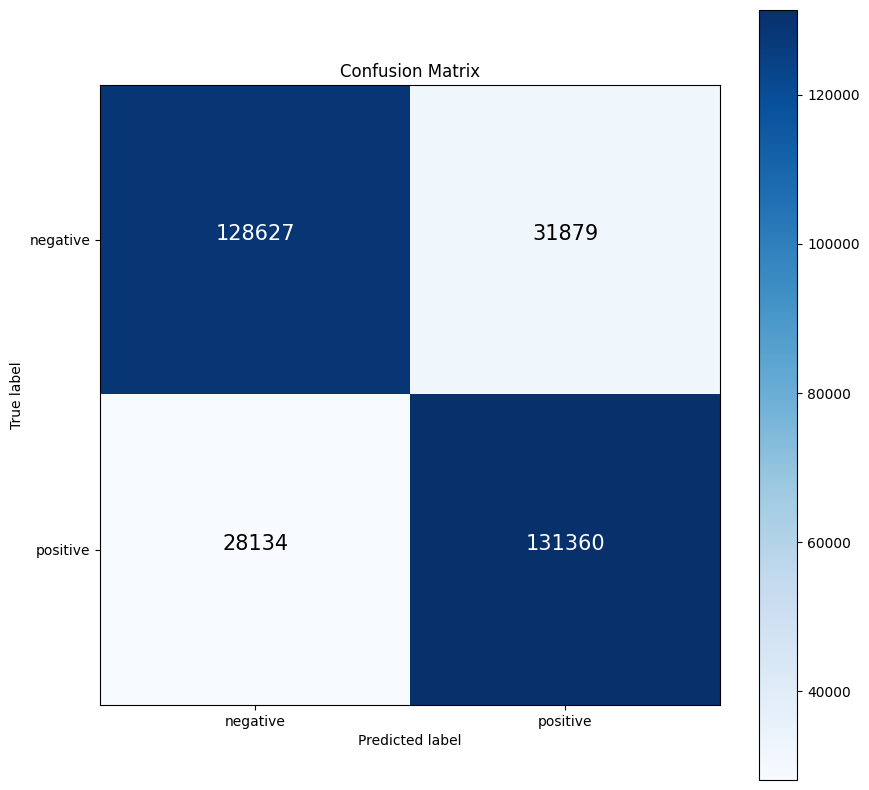

In [43]:
make_confusion_matrix(val_labels,model_1_preds,classes=["negative","positive"])

## Model 2: LSTM Model

### Creating text vectors and labels for the training of our LSTM model

In [44]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_features = len(words)
tokenizer_keras = Tokenizer(num_words=max_features, split=' ')
tokenizer_keras.fit_on_texts(new_data['text'].values)
X = tokenizer_keras.texts_to_sequences(new_data['text'].values)
X = pad_sequences(X)
y = np.asarray(new_data['target'])

In [45]:
X[:5],y[:5]

(array([[     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,  58407,     21,      7,     96],
        [     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
           6091,  12787,     31,     92,   4823,  67548],
        [     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
        

### Creating an Embedding using an Embedding layer

In [46]:
from tensorflow.keras import layers
embed_dim = 128

embedding = layers.Embedding(input_dim = max_features,
                             output_dim = embed_dim,
                             input_length=X.shape[1])
embedding

### Splitting data into train and test format

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,
                                                    random_state =42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1280000, 38), (320000, 38), (1280000,), (320000,))

In [48]:
# Creating a validation set
validation_size = 160000

X_validate = X_test[-validation_size:]
y_validate = y_test[-validation_size:]
X_test = X_test[:-validation_size]
y_test = y_test[:-validation_size]

In [49]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from keras.regularizers import L2
lstm_out = 196

model_2 = Sequential([
    Embedding(max_features, embed_dim,input_length = X.shape[1]),
    SpatialDropout1D(0.4),
    LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2),
    Dense(1,activation='sigmoid', kernel_regularizer=L2(0.001))
])


# Compiling the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 38, 128)           89781376  
                                                                 
 spatial_dropout1d (Spatial  (None, 38, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 1)                 197       
                                                                 
Total params: 90036373 (343.46 MB)
Trainable params: 90036373 (343.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
from keras import callbacks
# Creating an early stopping callback to restore the best state
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
model_2_history = model_2.fit(X_train, y_train, epochs = 20, batch_size=128, verbose = 1, validation_data=(X_validate, y_validate),
                    callbacks=[earlystopping])

Epoch 1/20
10000/10000 [==============================] - 1029s 102ms/step - loss: 0.4355 - accuracy: 0.7975 - val_loss: 0.4095 - val_accuracy: 0.8125
Epoch 2/20
10000/10000 [==============================] - 996s 100ms/step - loss: 0.3350 - accuracy: 0.8564 - val_loss: 0.4465 - val_accuracy: 0.7976
Epoch 3/20
10000/10000 [==============================] - 990s 99ms/step - loss: 0.2695 - accuracy: 0.8893 - val_loss: 0.4869 - val_accuracy: 0.7927
Epoch 4/20
10000/10000 [==============================] - 996s 100ms/step - loss: 0.2360 - accuracy: 0.9035 - val_loss: 0.5380 - val_accuracy: 0.7886
Epoch 5/20
10000/10000 [==============================] - 989s 99ms/step - loss: 0.2164 - accuracy: 0.9116 - val_loss: 0.5515 - val_accuracy: 0.7889
Epoch 6/20
10000/10000 [==============================] - 1041s 104ms/step - loss: 0.2027 - accuracy: 0.9173 - val_loss: 0.5873 - val_accuracy: 0.7912


In [51]:
# Make predictions
model_2_pred_probs = model_2.predict(X_test)
model_2_pred_probs[:10]

# Convert model 2 pred probs to labels format
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

5000/5000 [==============================] - 75s 15ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 0., 0., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate model 2 results
model_2_results = calculate_results(y_test,model_2_preds)
model_2_results

{'accuracy': 0.8135625,
 'precision': 0.8136656494200368,
 'recall': 0.8135625,
 'f1-score': 0.8135521295752193}

### Plotting confusion matrix of LSTM model

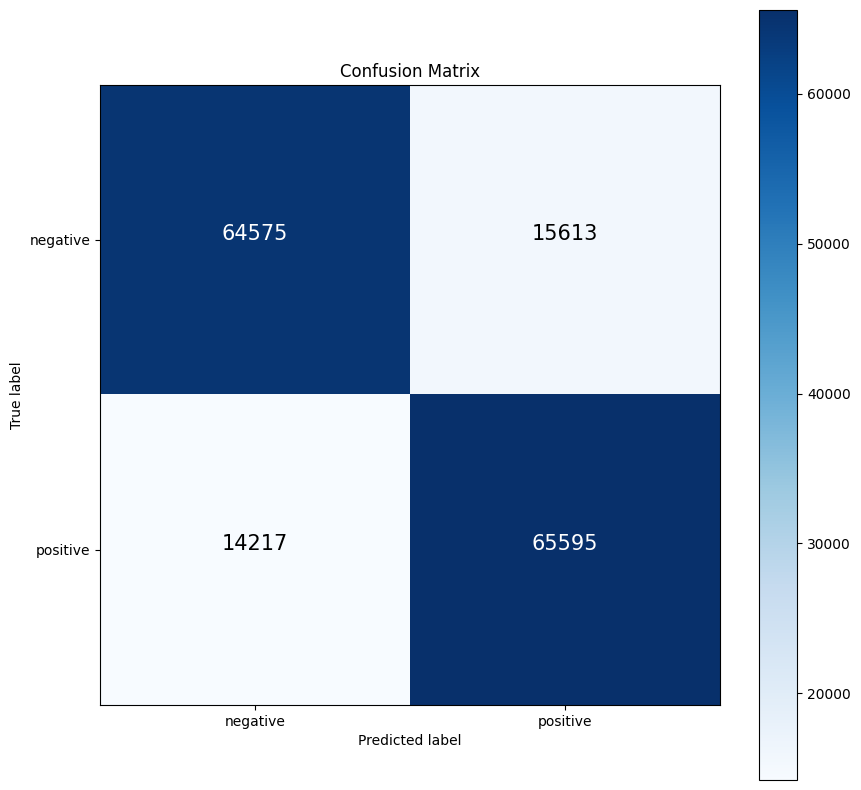

In [53]:
make_confusion_matrix(y_test,model_2_preds,classes=["negative","positive"])

### Creating a function to plot the separate loss curves for loss and accuracy

In [54]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



### Plotting loss curves for our LSTM model

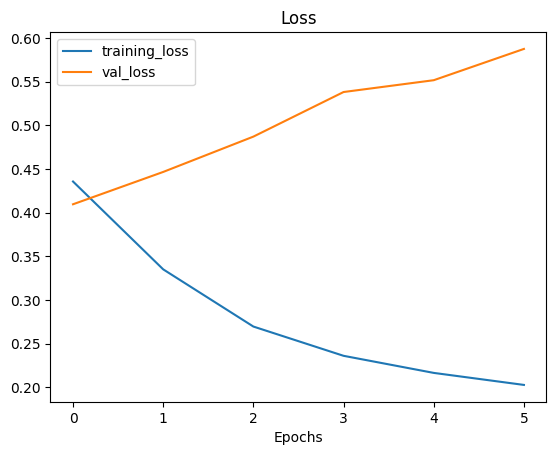

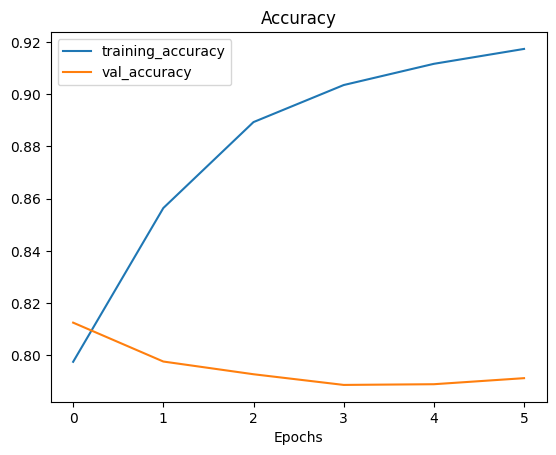

In [55]:
plot_loss_curves(model_2_history)

## Model 3: Using USE (Universal Sentence Encoder) through transfer learning

In [58]:
# Create a Keras layer for the universal sentence encoder
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/large/versions/3",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [59]:
# Create a model for the sentence encoder
model_3 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_3_USE")

# Compiling the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32897 (128.50 KB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  restore_best_weights=True)

In [63]:
train_sentences,train_labels

(array(['needs viagra no not internet connection like seriously wtf keep dropping',
        'headache missing dog tomorrow going visit grandma',
        'pidgen no longer connects mozilla often closes wont reopen view calendar ubuntu machine slowing dieing',
        ..., 'giving beamer good washhhh',
        'paulreid sorry sounded like year old texting tried tweetshrinking built tweed deck another cool feature',
        'cant wait see transformers cme shia yippiee'], dtype=object),
 array([0, 0, 0, ..., 1, 1, 1]))

In [64]:
# Train a classifier
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              batch_size=64,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[early_stopping])

Epoch 1/10
20000/20000 [==============================] - 1013s 51ms/step - loss: 0.4246 - accuracy: 0.8022 - val_loss: 0.4268 - val_accuracy: 0.8010
Epoch 2/10
20000/20000 [==============================] - 1009s 50ms/step - loss: 0.4221 - accuracy: 0.8033 - val_loss: 0.4270 - val_accuracy: 0.8011
Epoch 3/10
20000/20000 [==============================] - 1127s 56ms/step - loss: 0.4205 - accuracy: 0.8042 - val_loss: 0.4250 - val_accuracy: 0.8018
Epoch 4/10
20000/20000 [==============================] - 1014s 51ms/step - loss: 0.4192 - accuracy: 0.8048 - val_loss: 0.4241 - val_accuracy: 0.8027
Epoch 5/10
20000/20000 [==============================] - 1016s 51ms/step - loss: 0.4180 - accuracy: 0.8053 - val_loss: 0.4240 - val_accuracy: 0.8028
Epoch 6/10
20000/20000 [==============================] - 980s 49ms/step - loss: 0.4171 - accuracy: 0.8062 - val_loss: 0.4288 - val_accuracy: 0.8004
Epoch 7/10
20000/20000 [==============================] - 1010s 51ms/step - loss: 0.4163 - accuracy: 

In [65]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

10000/10000 [==============================] - 293s 29ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [66]:
model_3_results = calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 0.803590625,
 'precision': 0.8035937997782676,
 'recall': 0.803590625,
 'f1-score': 0.8035910851578937}

### Plotting the confusion matrix of model 3 (universal sentence encoder)

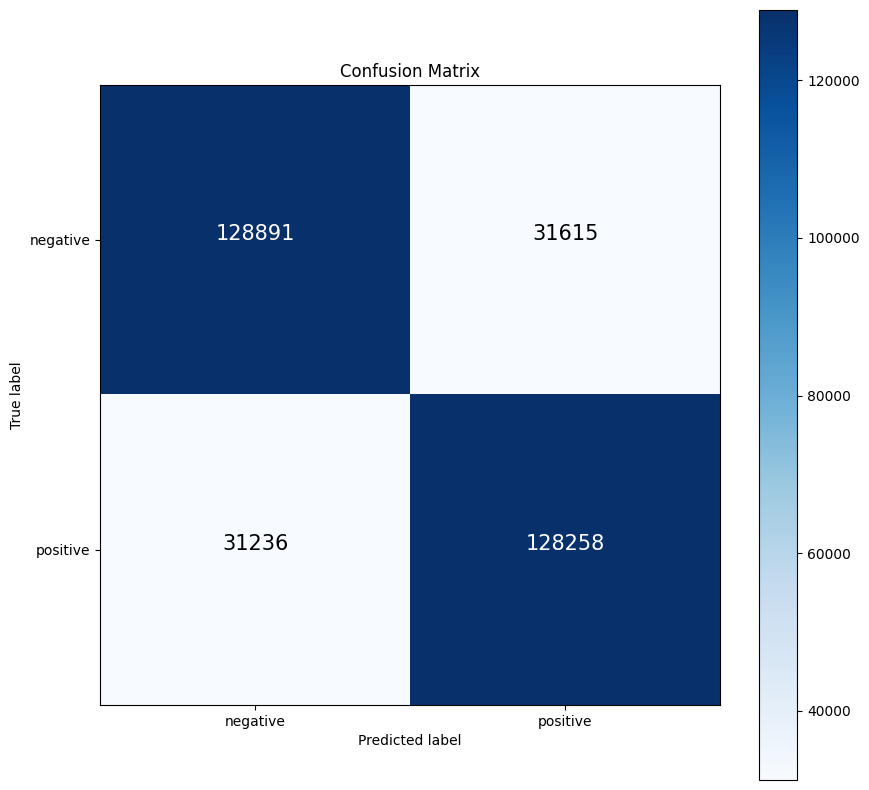

In [67]:
make_confusion_matrix(val_labels,model_3_preds,classes=["negative","positive"])

### Plotting the loss curves of model 3

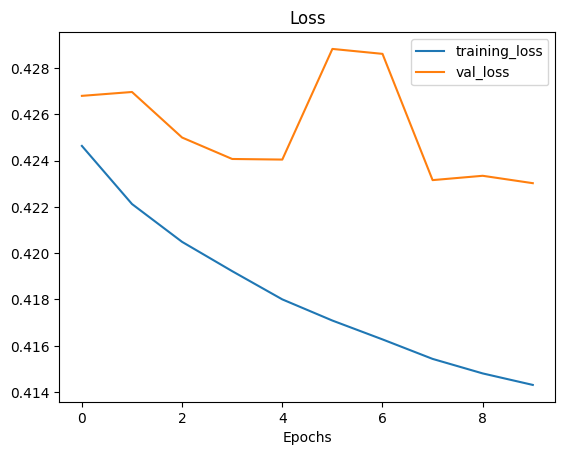

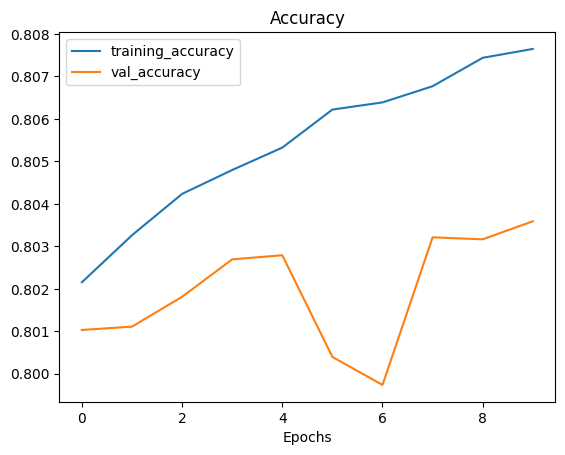

In [68]:
plot_loss_curves(model_3_history)

## Comparing all of our model results

In [69]:
all_model_results = pd.DataFrame({"0_naive_bayes":model_0_results,
                                  "1_Logistic_regression":model_1_results,
                                  "2_LSTM_model":model_2_results,
                                  "3_tf_hub_use_encoder":model_3_results})
all_model_results = all_model_results.transpose()

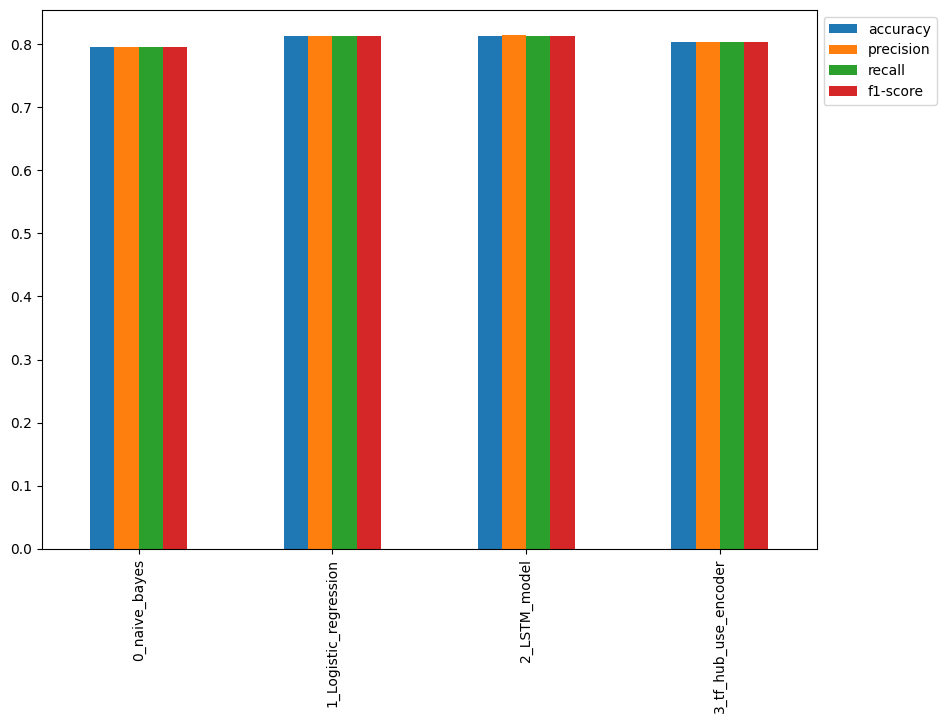

In [70]:
# Plottinng all of the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

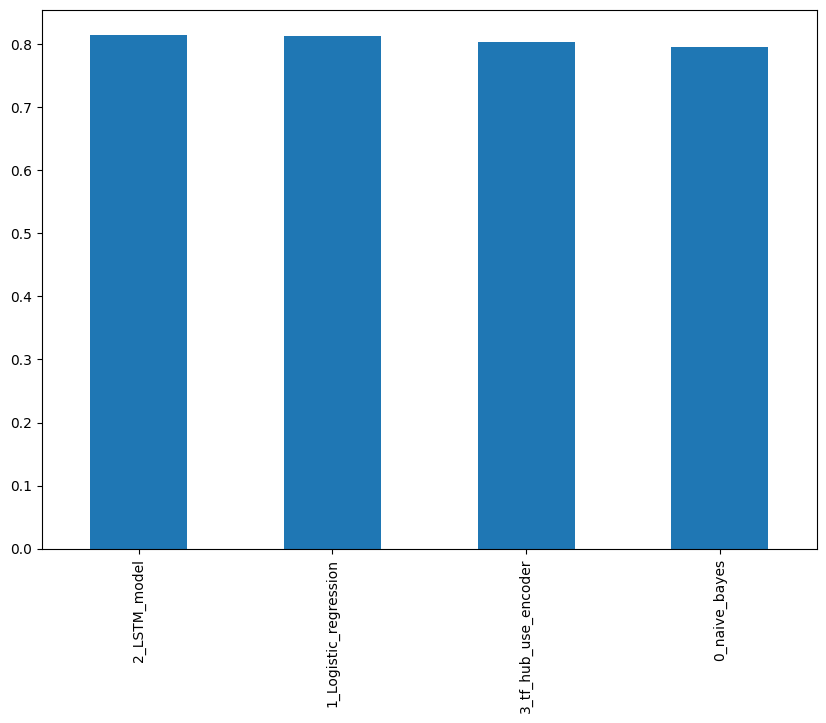

In [71]:
# Sort model results by f1_score
all_model_results.sort_values('f1-score',ascending=False)["f1-score"].plot(kind="bar",figsize=(10,7));

## Saving our best model so far

As we have tried various models now we know there performance on the data. Here we are selecting the best model from all of the 4 model's we have tried based on their f1-score and time. Here f1-score is a good matrix to evaluate our model cause it takes into account both precision and recall thus maintining a balance between false positives and false negatives

In [88]:
import joblib
model_file = open("/content/drive/MyDrive/logistic_regression_sentiment_analysis.pkl","wb")
joblib.dump(model_1,model_file)
model_file.close()

## Predicting on wild data

In [74]:
model_1.predict(["I really appreciate your hard work and dedication to this project"])

array([1])

In [75]:
model_1.predict(["Your lack of communication and missed deadlines have caused significant delays in the project."])

array([0])

In [76]:
comments = ["I really appreciate your hard work and dedication to this project.",
"Your creativity and ideas have been invaluable in shaping the direction of our team.",
"Thank you for your excellent communication and timely responses throughout this process.",
"Your attention to detail and commitment to quality are truly impressive.",
"I admire your positive attitude and ability to stay motivated even under challenging circumstances.",
"Your lack of communication and missed deadlines have caused significant delays in the project.",
"I'm disappointed with the quality of your work and the number of mistakes that need to be corrected.",
"Your negative attitude and lack of teamwork are affecting the morale of the entire team.",
"Your lack of initiative and proactivity are holding back the progress of the project.",
"Your disrespectful comments and behavior towards others are not acceptable in the workplace."]

In [83]:
model_0.predict(comments)

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [77]:
model_1.predict(comments)

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [84]:
X = tokenizer_keras.texts_to_sequences(comments)
X = pad_sequences(X)

In [85]:
tf.round(model_2.predict(X))

1/1 [==============================] - 0s 370ms/step


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [82]:
tf.round(model_3.predict(comments))

1/1 [==============================] - 0s 47ms/step


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

## Here we can see that model 2 and 3 predictions are more accurate on wild data then model 0 and 1 predictions.

## As model 2 is our best model so far so let's save that model

In [89]:
model_2.save("/content/drive/MyDrive/lstm_sentiment_analysis_model")